<a href="https://colab.research.google.com/github/Junumboxo/dlschool/blob/master/autoencoders_detailed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


## Prepare the data

In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

In [0]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [0]:
data_normalized = (data - data.min())/(data.max() - data.min())

X_train = data_normalized[:TRAIN_SIZE,:]
X_val = data_normalized[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE, :] 

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

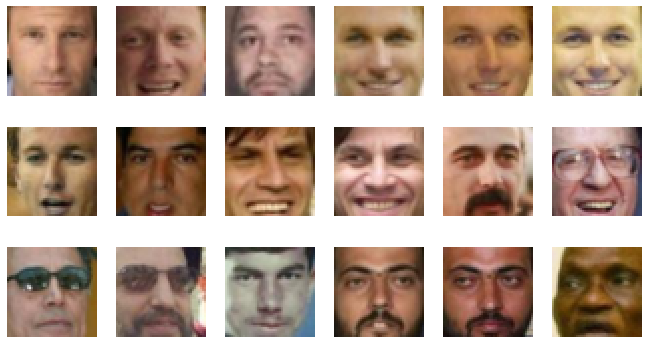

In [6]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [0]:
X_train = torch.Tensor(X_train)
X_val = torch.Tensor(X_val)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [0]:
inp_size=X_train.shape[1]
hid_size=256
dimZ=128

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [0]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_conv_1 = nn.Conv2d(3, 32, kernel_size = 3, stride=2, padding = 0)
        #self.encoder_conv_2 = nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding = 1)
        #self.dropout = nn.Dropout(p=0.3)
        self.encoder_linear_1 = nn.Linear(32*22*22, hid_size)
        self.encoder_linear_2 = nn.Linear(hid_size, dimZ)
        self.decoder_linear_2 = nn.Linear(dimZ, hid_size)
        self.decoder_linear_1 = nn.Linear(hid_size, 32*22*22)
        #self.decoder_conv_2 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride=1, padding = 1)
        self.decoder_conv_1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 3, stride=2, padding = 0)
    def encode(self, x, batch_size):
        x = F.elu(self.encoder_conv_1(x))
        #x = F.elu(self.encoder_conv_2(x))
        #print(x.shape)
        x = x.view(-1, 32*22*22) 
        x = F.elu(self.encoder_linear_1(x))
        latent_code = F.elu(self.encoder_linear_2(x))
        return latent_code
    def decode(self, latent_code, batch_size):
        x = F.elu(self.decoder_linear_2(latent_code))
        x = F.elu(self.decoder_linear_1(x))
        x = x.view(batch_size, 32, 22, 22)
        #x = F.elu(self.decoder_conv_2(x))
        reconstruction = F.sigmoid(self.decoder_conv_1(x))
        return reconstruction
    def forward(self, x, batch_size):
        latent_code = self.encode(x, batch_size)
        reconstruction = self.decode(latent_code, batch_size)
        return reconstruction, latent_code

In [0]:
criterion = nn.MSELoss()

autoencoder = Autoencoder().cuda()

learning_rate = 1e-4
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [0]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(X_train, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_val, batch_size, shuffle=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


epoch [1], train loss:0.0293, val loss:0.0189
epoch [2], train loss:0.0153, val loss:0.0132
epoch [3], train loss:0.0123, val loss:0.0114
epoch [4], train loss:0.0109, val loss:0.0103
epoch [5], train loss:0.0100, val loss:0.0095
epoch [6], train loss:0.0092, val loss:0.0088
epoch [7], train loss:0.0085, val loss:0.0081
epoch [8], train loss:0.0080, val loss:0.0076
epoch [9], train loss:0.0075, val loss:0.0073
epoch [10], train loss:0.0072, val loss:0.0070
epoch [11], train loss:0.0069, val loss:0.0067
epoch [12], train loss:0.0066, val loss:0.0064
epoch [13], train loss:0.0064, val loss:0.0062
epoch [14], train loss:0.0062, val loss:0.0060
epoch [15], train loss:0.0059, val loss:0.0058
epoch [16], train loss:0.0058, val loss:0.0056
epoch [17], train loss:0.0056, val loss:0.0054
epoch [18], train loss:0.0054, val loss:0.0053
epoch [19], train loss:0.0053, val loss:0.0052
epoch [20], train loss:0.0052, val loss:0.0051
epoch [21], train loss:0.0050, val loss:0.0049
epoch [22], train loss

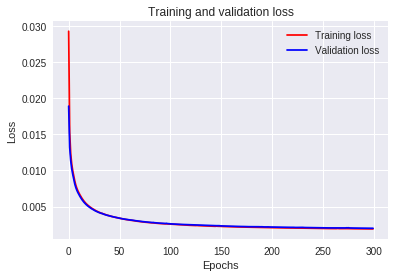

In [282]:
epochs = 300
loss_train_total = []
loss_val_total = []

for epoch in range(epochs):
    loss_train_append = 0
    for data in train_loader:
        image_train = data
        image_train = Variable(image_train.cuda(), volatile=True)
        image_train = image_train.view(image_train.shape[0], 3, 45, 45)
        image_train_reconstructed, code = autoencoder(image_train, image_train.shape[0])
        loss_train = criterion(image_train_reconstructed, image_train)
        loss_train_append+=loss_train.item()
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    loss_train_append /= len(train_loader)
    loss_train_total.append(loss_train_append)
    
    loss_val_append = 0
    for data in test_loader:
        image_val = data
        image_val = Variable(image_val.cuda(), volatile=True)
        image_val = image_val.view(image_val.shape[0], 3, 45, 45)
        image_val_reconstructed, code = autoencoder(image_val, image_val.shape[0])
        loss_val = criterion(image_val_reconstructed, image_val)
        loss_val_append+=loss_val.item()
    loss_val_append /= len(test_loader)
    loss_val_total.append(loss_val_append)
    print('epoch [{}], train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train_total[epoch], loss_val_total[epoch]))

plt.plot([i for i in range(epochs)], loss_train_total, c='r', label='Training loss')
plt.plot([i for i in range(epochs)], loss_val_total, c = 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()    

In [0]:
torch.save(autoencoder.state_dict(), 'Autoencoder_standart.pt') 
autoencoder.load_state_dict(torch.load('Autoencoder_standart.pt'))

#**Denoising

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


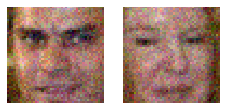

In [693]:
noise_factor = 0.07
X_train_noisy = X_train.numpy() + noise_factor * np.random.normal(size=X_train.shape)
X_val_noisy = X_val.numpy() + noise_factor * np.random.normal(size=X_val.shape)
plot_gallery(X_val_noisy, IMAGE_H, IMAGE_W, n_row=1, n_col=2)
batch_size = 100
train_loader = torch.utils.data.DataLoader(torch.Tensor(X_train_noisy), batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.Tensor(X_val_noisy), batch_size, shuffle=False)


In [0]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_conv_1 = nn.Conv2d(3, 8, kernel_size = 3, stride=1, padding = 0)
        self.encoder_conv_2 = nn.Conv2d(8, 16, kernel_size = 3, stride=1, padding = 1)
        #self.dropout = nn.Dropout(p=0.3)
        self.encoder_linear_1 = nn.Linear(16*43*43, hid_size)
        self.encoder_linear_2 = nn.Linear(hid_size, dimZ)
        self.decoder_linear_2 = nn.Linear(dimZ, hid_size)
        self.decoder_linear_1 = nn.Linear(hid_size, 16*43*43)
        self.decoder_conv_2 = nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride=1, padding = 1)
        self.decoder_conv_1 = nn.ConvTranspose2d(in_channels = 8, out_channels = 3, kernel_size = 3, stride=1, padding = 0)
    def encode(self, x, batch_size):
        x = F.elu(self.encoder_conv_1(x))
        x = F.elu(self.encoder_conv_2(x))
        #print(x.shape)
        x = x.view(-1, 16*43*43) 
        x = F.elu(self.encoder_linear_1(x))
        latent_code = F.elu(self.encoder_linear_2(x))
        return latent_code
    def decode(self, latent_code, batch_size):
        x = F.elu(self.decoder_linear_2(latent_code))
        x = F.elu(self.decoder_linear_1(x))
        x = x.view(batch_size, 16, 43, 43)
        x = F.elu(self.decoder_conv_2(x))
        reconstruction = F.sigmoid(self.decoder_conv_1(x))
        return reconstruction
    def forward(self, x, batch_size):
        latent_code = self.encode(x, batch_size)
        reconstruction = self.decode(latent_code, batch_size)
        return reconstruction, latent_code

In [0]:
criterion = nn.MSELoss()

autoencoder_noise = Autoencoder().cuda()

learning_rate = 1e-4
optimizer = optim.Adam(autoencoder_noise.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch [1], train loss:0.0342, val loss:0.0255
epoch [2], train loss:0.0237, val loss:0.0213
epoch [3], train loss:0.0199, val loss:0.0189
epoch [4], train loss:0.0180, val loss:0.0170
epoch [5], train loss:0.0165, val loss:0.0157
epoch [6], train loss:0.0153, val loss:0.0147
epoch [7], train loss:0.0144, val loss:0.0140
epoch [8], train loss:0.0138, val loss:0.0135
epoch [9], train loss:0.0134, val loss:0.0131
epoch [10], train loss:0.0130, val loss:0.0128
epoch [11], train loss:0.0127, val loss:0.0125
epoch [12], train loss:0.0124, val loss:0.0122
epoch [13], train loss:0.0122, val loss:0.0120
epoch [14], train loss:0.0119, val loss:0.0117
epoch [15], train loss:0.0117, val loss:0.0115
epoch [16], train loss:0.0115, val loss:0.0114
epoch [17], train loss:0.0113, val loss:0.0112
epoch [18], train loss:0.0111, val loss:0.0110
epoch [19], train loss:0.0110, val loss:0.0109
epoch [20], train loss:0.0108, val loss:0.0107
epoch [21], train loss:0.0107, val loss:0.0106
epoch [22], train loss

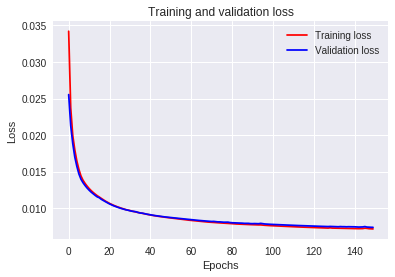

In [702]:
epochs = 150
loss_train_total = []
loss_val_total = []

for epoch in range(epochs):
    loss_train_append = 0
    for data in train_loader:
        image_train = data
        image_train = Variable(image_train.cuda(), volatile=True)
        image_train = image_train.view(image_train.shape[0], 3, 45, 45)
        image_train_reconstructed, code = autoencoder_noise(image_train, image_train.shape[0])
        loss_train = criterion(image_train_reconstructed, image_train)
        loss_train_append+=loss_train.item()
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    loss_train_append /= len(train_loader)
    loss_train_total.append(loss_train_append)
    
    loss_val_append = 0
    for data in test_loader:
        image_val = data
        image_val = image_val.view(image_val.shape[0], 3, 45, 45).cuda()
        image_val_reconstructed, code = autoencoder_noise(image_val, image_val.shape[0])
        loss_val = criterion(image_val_reconstructed, image_val)
        loss_val_append+=loss_val.item()
    loss_val_append /= len(test_loader)
    loss_val_total.append(loss_val_append)
    print('epoch [{}], train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train_total[epoch], loss_val_total[epoch]))

plt.plot([i for i in range(epochs)], loss_train_total, c='r', label='Training loss')
plt.plot([i for i in range(epochs)], loss_val_total, c = 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()    

In [0]:
#torch.save(autoencoder_noise.state_dict(), 'Autoencoder_noise.pt') 
#autoencoder_noise = torch.load('Autoencoder_noise.pt')
autoencoder_noise = Autoencoder()
autoencoder_noise.load_state_dict(torch.load('Autoencoder_noise.pt'))
autoencoder_noise.eval()

#**Denoising_2

In [0]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder_conv_1 = nn.Conv2d(3, 16, kernel_size = 3, stride=2, padding = 1)
        #self.encoder_conv_2 = nn.Conv2d(8, 16, kernel_size = 3, stride=2, padding = 1)
        self.pool = nn.MaxPool2d(2, stride = 1)
        self.encoder_linear_1 = nn.Linear(16*22*22, hid_size)
        self.encoder_linear_2 = nn.Linear(hid_size, dimZ)
        self.decoder_linear_2 = nn.Linear(dimZ, hid_size)
        self.decoder_linear_1 = nn.Linear(hid_size, 16*22*22)
        self.up = nn.UpsamplingBilinear2d(size = (23, 23))
        #self.decoder_conv_2 = nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride=2, padding = 1)
        self.decoder_conv_1 = nn.ConvTranspose2d(in_channels = 16, out_channels = 3, kernel_size = 3, stride=2, padding = 1)
    def encode(self, x, batch_size):
        x = self.pool(F.elu(self.encoder_conv_1(x)))
        #x = F.elu(self.encoder_conv_2(x))
        #print(x.shape)
        x = x.view(-1, 16*22*22) 
        x = F.elu(self.encoder_linear_1(x))
        latent_code = F.elu(self.encoder_linear_2(x))
        return latent_code
    def decode(self, latent_code, batch_size):
        x = F.elu(self.decoder_linear_2(latent_code))
        x = F.elu(self.decoder_linear_1(x))
        x = self.up(x.view(batch_size, 16, 22, 22))
        #x = F.elu(self.decoder_conv_2(x))
        reconstruction = F.sigmoid(self.decoder_conv_1(x))
        return reconstruction
    def forward(self, x, batch_size):
        latent_code = self.encode(x, batch_size)
        reconstruction = self.decode(latent_code, batch_size)
        return reconstruction, latent_code

In [0]:
criterion = nn.MSELoss()

autoencoder_noise = Autoencoder().cuda()

learning_rate = 1e-4
optimizer = optim.Adam(autoencoder_noise.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch [1], train loss:0.0386, val loss:0.0330
epoch [2], train loss:0.0292, val loss:0.0256
epoch [3], train loss:0.0233, val loss:0.0211
epoch [4], train loss:0.0201, val loss:0.0190
epoch [5], train loss:0.0186, val loss:0.0180
epoch [6], train loss:0.0177, val loss:0.0173
epoch [7], train loss:0.0172, val loss:0.0169
epoch [8], train loss:0.0168, val loss:0.0165
epoch [9], train loss:0.0164, val loss:0.0161
epoch [10], train loss:0.0161, val loss:0.0158
epoch [11], train loss:0.0158, val loss:0.0155
epoch [12], train loss:0.0154, val loss:0.0151
epoch [13], train loss:0.0151, val loss:0.0149
epoch [14], train loss:0.0149, val loss:0.0147
epoch [15], train loss:0.0147, val loss:0.0145
epoch [16], train loss:0.0145, val loss:0.0143
epoch [17], train loss:0.0143, val loss:0.0141
epoch [18], train loss:0.0141, val loss:0.0139
epoch [19], train loss:0.0139, val loss:0.0138
epoch [20], train loss:0.0138, val loss:0.0136
epoch [21], train loss:0.0136, val loss:0.0135
epoch [22], train loss

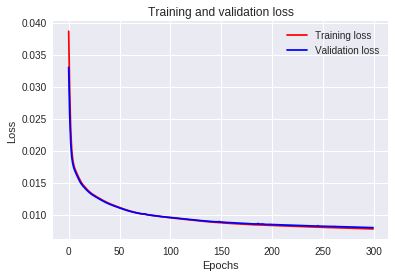

In [643]:
epochs = 300
loss_train_total = []
loss_val_total = []

for epoch in range(epochs):
    loss_train_append = 0
    for data in train_loader:
        image_train = data
        image_train = Variable(image_train.cuda(), volatile=True)
        image_train = image_train.view(image_train.shape[0], 3, 45, 45)
        image_train_reconstructed, code = autoencoder_noise(image_train, image_train.shape[0])
        loss_train = criterion(image_train_reconstructed, image_train)
        loss_train_append+=loss_train.item()
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
    loss_train_append /= len(train_loader)
    loss_train_total.append(loss_train_append)
    
    loss_val_append = 0
    for data in test_loader:
        image_val = data
        image_val = image_val.view(image_val.shape[0], 3, 45, 45).cuda()
        image_val_reconstructed, code = autoencoder_noise(image_val, image_val.shape[0])
        loss_val = criterion(image_val_reconstructed, image_val)
        loss_val_append+=loss_val.item()
    loss_val_append /= len(test_loader)
    loss_val_total.append(loss_val_append)
    print('epoch [{}], train loss:{:.4f}, val loss:{:.4f}'.format(epoch+1, loss_train_total[epoch], loss_val_total[epoch]))

plt.plot([i for i in range(epochs)], loss_train_total, c='r', label='Training loss')
plt.plot([i for i in range(epochs)], loss_val_total, c = 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


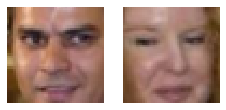

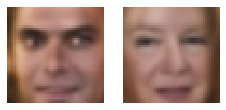

In [14]:
X_val_reconstructed, _ = autoencoder(Variable(X_val.view(-1,3,45,45)).cuda(), len(X_val))
X_val_reconstructed = X_val_reconstructed.view(-1,45,45,3).data.cpu().numpy() 
plot_gallery(X_val, IMAGE_H, IMAGE_W, n_row=1, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=1, n_col=2)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


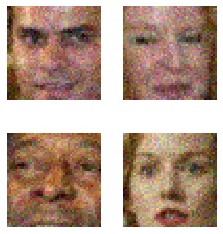

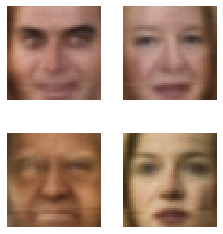

In [644]:
X_val_reconstructed, _ = autoencoder_noise((Variable(torch.Tensor(X_val_noisy)).view(-1,3,45,45)).cuda(), len(X_val))
X_val_reconstructed = X_val_reconstructed.view(-1,45,45,3).data.cpu().numpy() 
plot_gallery(X_val_noisy, IMAGE_H, IMAGE_W, n_row=2, n_col=2)
plot_gallery(X_val_reconstructed, IMAGE_H, IMAGE_W, n_row=2, n_col=2)

Not bad, right? 

# Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


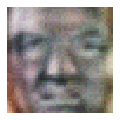

In [402]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.normal(size = (25, dimZ))
#z = (z - z.min())/(z.max() - z.min())
z = torch.Tensor(z).cuda()
output = autoencoder.decode(z, batch_size=25)
output = output.view(25, 45, 45, 3)
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

# Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

6295


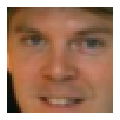

In [477]:
import math
ind = math.floor(np.random.random_sample()*TRAIN_SIZE)
print(ind)
plot_gallery(X_train[ind].reshape(1,45,45,3), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

In [0]:
indices_happy = [517, 3218, 7060, 1427, 9014, 7096, 5786, 819, 2283, 640, 5882, 8533, 3328, 7366, 6295]
indices_sad = [1230, 6384, 8695, 7399, 8931, 6493, 5927, 6024, 2322, 3197, 4152, 7587, 3918, 1556, 8730]

In [0]:
def encode(x):
    return autoencoder_noise.encode(x, batch_size = 1)
def decode(x):
    return autoencoder_noise.decode(x, batch_size = 1)
  
codes_happy = torch.Tensor(np.zeros(dimZ).reshape(1, dimZ)).cuda()
codes_sad = torch.Tensor(np.zeros(dimZ).reshape(1, dimZ)).cuda()

for index in indices_happy:
    code_happy = encode(torch.Tensor(X_train[index].reshape(1, 3, 45, 45)).cuda())
    codes_happy = codes_happy.add(code_happy)
code_happy_mean = codes_happy/len(indices_happy)

for index in indices_sad:
    code_sad = encode(torch.Tensor(X_train[index].reshape(1, 3, 45, 45)).cuda())
    codes_sad = codes_sad.add(code_sad)
code_sad_mean = codes_sad/len(indices_sad)

code_smile = code_happy_mean.sub(code_sad_mean)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


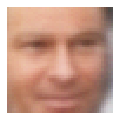

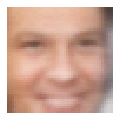

In [656]:
X_sad, code_X_sad = autoencoder_noise(torch.Tensor(X_train[np.random.choice(indices_sad)].reshape(1, 3, 45, 45)).cuda(), batch_size = 1)
code_X_not_sad = code_X_sad.add(code_smile)
X_not_sad = decode(code_X_not_sad)

plot_gallery(X_sad.data.cpu().numpy().reshape(1, 45, 45, 3), IMAGE_H, IMAGE_W, n_row=1, n_col=1)
plot_gallery(X_not_sad.data.cpu().numpy().reshape(1, 45, 45, 3), IMAGE_H, IMAGE_W, n_row=1, n_col=1)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# BONUS 1. 
### Variational Autoencoder

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [0]:
class VAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        <реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>
        
        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, mu_z, reconstruction

Определим лосс и его компоненты для VAE:

In [0]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -(1/2) * (1 + 2*logsigma - mu**2 - torch.exp(logsigma)**2).sum(dim=-1)

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return -(-KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)).mean()

И обучим модель:

In [0]:
criterion = <MSE LOSS>

autoencoder = Autoencoder()

optimizer = <Ваш любимый оптимизатор>

In [0]:
<обучите модель, как и autoencoder>

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [0]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

And finally sample from VAE.

# Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

In [0]:
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

# Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [0]:
<как вы уже догадались, тут Ваш код>